**Importing necessary Libraries**

In [4]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
import gc
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

**Importing the dataset**

In [5]:
# Defining the datatype of each column for reading the CSV file
dataTypes = {
    "UniqueID": np.uint16,
    "disbursed_amount": np.float64,
    "asset_cost": np.float64,
    "ltv": np.float64,
    "branch_id": np.object,
    "supplier_id": np.object,
    "manufacturer_id": np.object,
    "Current_pincode_ID": np.object,
    "Date.of.Birth": np.object,
    "Employment.Type": np.object,
    "DisbursalDate": np.object,
    "State_ID": np.object,
    "Employee_code_ID": np.object,
    "MobileNo_Avl_Flag": np.uint8,
    "Aadhar_flag": np.uint8,
    "PAN_flag": np.uint8,
    "VoterID_flag": np.uint8,
    "Driving_flag": np.uint8,
    "Passport_flag": np.uint8,
    "PERFORM_CNS.SCORE": np.uint16,
    "PERFORM_CNS.SCORE.DESCRIPTION": np.object,
    "PRI.NO.OF.ACCTS": np.uint8,
    "PRI.ACTIVE.ACCTS": np.uint8,
    "PRI.OVERDUE.ACCTS": np.uint8,
    "PRI.CURRENT.BALANCE": np.float64,
    "PRI.SANCTIONED.AMOUNT": np.float64,
    "PRI.DISBURSED.AMOUNT": np.float64,
    "SEC.NO.OF.ACCTS": np.uint8,
    "SEC.ACTIVE.ACCTS": np.uint8,
    "SEC.OVERDUE.ACCTS": np.uint8,
    "SEC.CURRENT.BALANCE": np.float64,
    "SEC.SANCTIONED.AMOUNT": np.float64,
    "SEC.DISBURSED.AMOUNT": np.float64,
    "PRIMARY.INSTAL.AMT": np.float64,
    "SEC.INSTAL.AMT": np.float64,
    "NEW.ACCTS.IN.LAST.SIX.MONTHS": np.uint8,
    "DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS": np.uint8,
    "AVERAGE.ACCT.AGE": np.object,
    "CREDIT.HISTORY.LENGTH": np.object,
    "NO.OF_INQUIRIES": np.uint8,
    "loan_default": np.uint8
}

# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
data = pd.read_csv("../data/train.csv", dtype=dataTypes)

**Function common to various part of the code**

In [6]:
# Extract year and month from the duration fields (input format Xyrs Ymons -> output X*12+Y)
def parseDuration(x):
    x_yrs = x.split()[0]
    x_mon = x.split()[1]
    n_years = x_yrs[:(len(x_yrs)-3)]
    n_mon = x_mon[:(len(x_mon)-3)]
    return int(n_years) * 12 + int(n_mon)

# Standardise the date format
def parseDate(v):
    if v.split("-")[-1]=='00' or v.split("-")[-1]=='18':
        return "-".join(v.split("-")[:-1])+'-20'+"".join(v.split("-")[-1])
    else:
        return "-".join(v.split("-")[:-1])+'-19'+"".join(v.split("-")[-1])

# Remove outliers from the data columns
def removeOutliers(data):
    data['disbursed_amount'] = np.clip(data['disbursed_amount'], a_min=25000, a_max = 80000)
    data['asset_cost'] = np.clip(data['asset_cost'], a_min=45000, a_max = 100000)
    data['ltv'] = np.clip(data['ltv'], a_min=40, a_max = 100)
    data['PRI.NO.OF.ACCTS'] = np.clip(data['PRI.NO.OF.ACCTS'], a_min=0, a_max = 10)
    data['PRI.ACTIVE.ACCTS'] = np.clip(data['PRI.ACTIVE.ACCTS'], a_min=0, a_max = 10)
    data['PRI.OVERDUE.ACCTS'] = np.clip(data['PRI.OVERDUE.ACCTS'], a_min=0, a_max = 5)
    data['PRI.CURRENT.BALANCE'] = np.clip(data['PRI.CURRENT.BALANCE'], a_min=0, a_max = 500000)
    data['PRI.SANCTIONED.AMOUNT'] = np.clip(data['PRI.SANCTIONED.AMOUNT'], a_min=0, a_max = 500000)
    data['PRI.DISBURSED.AMOUNT'] = np.clip(data['PRI.DISBURSED.AMOUNT'], a_min=0, a_max = 500000)
    data['SEC.NO.OF.ACCTS'] = np.clip(data['SEC.NO.OF.ACCTS'], a_min=0, a_max = 5)
    data['SEC.ACTIVE.ACCTS'] = np.clip(data['SEC.ACTIVE.ACCTS'], a_min=0, a_max = 3)
    data['SEC.OVERDUE.ACCTS'] = np.clip(data['SEC.OVERDUE.ACCTS'], a_min=0, a_max = 1)
    data['SEC.CURRENT.BALANCE'] = np.clip(data['SEC.CURRENT.BALANCE'], a_min=0, a_max = 100000)
    data['SEC.SANCTIONED.AMOUNT'] = np.clip(data['SEC.SANCTIONED.AMOUNT'], a_min=0, a_max = 100000)
    data['SEC.DISBURSED.AMOUNT'] = np.clip(data['SEC.DISBURSED.AMOUNT'], a_min=0, a_max = 100000)
    data['PRIMARY.INSTAL.AMT'] = np.clip(data['PRIMARY.INSTAL.AMT'], a_min=0, a_max = 10000)
    data['SEC.INSTAL.AMT'] = np.clip(data['SEC.INSTAL.AMT'], a_min=0, a_max = 2000)
    data['NEW.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(data['NEW.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 4)
    data['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'] = np.clip(data['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'], a_min=0, a_max = 5)
    data['AVERAGE.ACCT.AGE'] = np.clip(data['AVERAGE.ACCT.AGE'], a_min=0, a_max = 48)
    data['CREDIT.HISTORY.LENGTH'] = np.clip(data['CREDIT.HISTORY.LENGTH'], a_min=0, a_max = 120)
    data['NO.OF_INQUIRIES'] = np.clip(data['NO.OF_INQUIRIES'], a_min=0, a_max = 20)

# Clean the data
def preProcessData(data):
    data['Date.of.Birth'] = pd.to_datetime(data['Date.of.Birth'].apply(parseDate), format='%d-%m-%Y', errors='coerce')
    data['DisbursalDate'] = pd.to_datetime(data['DisbursalDate'].apply(parseDate), format='%d-%m-%Y')
    data['AgeAtDisbursal'] = (data['DisbursalDate'] - data['Date.of.Birth']).astype('<m8[Y]')
    
    data['Employment.Type'].fillna('Other', inplace=True)
    data['Employment.Type'] = pd.Categorical(data['Employment.Type'])
    data['EMP_TYPE'] = data['Employment.Type'].cat.codes
    
    data['AVERAGE.ACCT.AGE'] = data['AVERAGE.ACCT.AGE'].apply(parseDuration)
    data['CREDIT.HISTORY.LENGTH'] = data['CREDIT.HISTORY.LENGTH'].apply(parseDuration)
    
    data['PERFORM_CNS.SCORE.DESCRIPTION'] = pd.Categorical(data['PERFORM_CNS.SCORE.DESCRIPTION'])
    data['CNS_DESC_CODES'] = data['PERFORM_CNS.SCORE.DESCRIPTION'].cat.codes
    
    removeOutliers(data)
    
    data['Sanctioned'] = (data['asset_cost'] * (data['ltv'] / 100)).astype(np.float64)
    data['TOTAL.ACTIVE.ACCTS'] = (data['PRI.ACTIVE.ACCTS'] + data['SEC.ACTIVE.ACCTS']).astype(np.int64)
    data['TOTAL.CURRENT.BALANCE'] = (data['PRI.CURRENT.BALANCE'] + data['SEC.CURRENT.BALANCE']).astype(np.float64)
    data['TOTAL.DISBURSED.AMOUNT'] = (data['PRI.DISBURSED.AMOUNT'] + data['SEC.DISBURSED.AMOUNT']).astype(np.int64)
    data['TOTAL.NO.OF.ACCTS'] = (data['PRI.NO.OF.ACCTS'] + data['SEC.NO.OF.ACCTS']).astype(np.int64)
    data['TOTAL.OVERDUE.ACCTS'] = (data['PRI.OVERDUE.ACCTS'] + data['SEC.OVERDUE.ACCTS']).astype(np.int64)
    data['TOTAL.CLEAN.ACCTS'] = (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.OVERDUE.ACCTS']).astype(np.int64)
    data['NO.OF.ACC.BF.SIX.MONTH'] = (data['TOTAL.NO.OF.ACCTS'] - data['NEW.ACCTS.IN.LAST.SIX.MONTHS']).astype(np.int64)
    data['OVERDUE.ACC.BF.SIX.MONTHS'] = (data['TOTAL.OVERDUE.ACCTS'] - data['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']).astype(np.int64)
    data['TOTAL.DEACTIVE.ACCTS'] = (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.ACTIVE.ACCTS']).astype(np.int64)
    data['TOTAL.INSTL.AMOUNT'] = (data['PRIMARY.INSTAL.AMT'] + data['SEC.INSTAL.AMT']).astype(np.float64)
    data['TOTAL.CLEARED.ACCTS']= (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.ACTIVE.ACCTS'] + data['TOTAL.OVERDUE.ACCTS']).astype(np.int64)
    
    
    columnsToDrop = {
        "UniqueID",
        "Date.of.Birth",
        "DisbursalDate",
        'PERFORM_CNS.SCORE.DESCRIPTION',
        'Employment.Type'    
    }

    data = data.drop(columnsToDrop, axis=1)
    data = pd.get_dummies(data, prefix=['ET','SID','ECID','PCS','PCSD','MI','BI'],
                          columns=['EMP_TYPE','State_ID','Employee_code_ID','PERFORM_CNS.SCORE','CNS_DESC_CODES','manufacturer_id','branch_id'],drop_first=1)
    print("Done")
    return data

# Drop unimportant columns based on the feature importance from C5.0
def dropUnImportantFeatures(X, clf, threshold):
    feature_importances = pd.DataFrame(clf.feature_importances_, index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
    columnsToDrop = feature_importances[feature_importances['importance'] <= threshold].index.values
    print('Dropped column count: ',len(columnsToDrop))
    return X.drop(columnsToDrop, axis=1)

# ROC AUC Curve
def getAuc(model, X_test, y_test):
    predict_prob = model.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, predict_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

# ROC AUC Curve
def printAuc(model, X_test, y_test):
    predict_prob = model.predict_proba(X_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, predict_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC Score: ", roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Normalize data
def normalize(X_train, X_test):
    scaler = StandardScaler()  
    scaler.fit(X_train)
    return scaler.transform(X_train), scaler.transform(X_test)

# CV on the training set
def crossValidate(model, a, b):
    return cross_val_score(estimator=model, X=a, y=b, cv=3, scoring='roc_auc')

# Perform C5.0 classification for dimension reduction
def featureExtraction(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
    model = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train)
    printAuc(model, X_test, y_test)
    del X_train
    del X_test
    del y_train
    del y_test
    gc.collect()
    return model
    
def C50(X_train, X_test, y_train, y_test):
    model = tree.DecisionTreeClassifier()
    cvScore = crossValidate(model, X_train, y_train)
    print("Mean CV Training ROC AUC Score: ", np.mean(cvScore))
    model.fit(X_train, y_train)
    printAuc(model, X_test, y_test)

def NB(X_train, X_test, y_train, y_test):
    model = GaussianNB(priors=None, var_smoothing=10e-90)
    cvScore = crossValidate(model, X_train, y_train)
    print("Mean CV Training ROC AUC Score: ", np.mean(cvScore))
    model.fit(X_train, y_train)
    printAuc(model, X_test, y_test)

def KNN(X_train, X_test, y_train, y_test):
    train, test = normalize(X_train, X_test)
    print("Running the model for k = ", 83)
    model = KNeighborsClassifier(n_neighbors=83, weights='distance')
    model.fit(train, y_train)
    printAuc(model, test, y_test)
    
def RF(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=1898, min_samples_split=10, min_samples_leaf=6,
                               max_features='auto', max_depth=40, criterion='entropy', bootstrap=True)
    cvScore = crossValidate(model, X_train, y_train)
    print("Mean CV Training ROC AUC Score: ", np.mean(cvScore))
    model.fit(X_train, y_train)
    printAuc(model, X_test, y_test)

In [7]:
data = preProcessData(data)

Done


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Columns: 4018 entries, disbursed_amount to BI_97
dtypes: float64(15), int64(11), object(2), uint8(3990)
memory usage: 937.0+ MB


In [9]:
X = data.drop('loan_default', 1)
y = data['loan_default']
del data
gc.collect()

25

ROC AUC Score:  0.5319241712123753


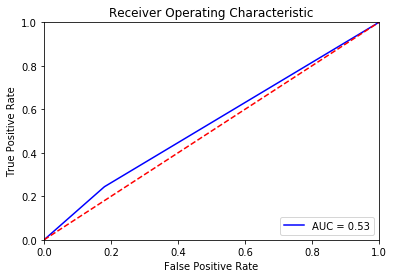

In [10]:
clf = featureExtraction(X)

In [11]:
X = dropUnImportantFeatures(X, clf, 0.0002)
X.info()

Dropped column count:  3514
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Columns: 503 entries, disbursed_amount to BI_97
dtypes: float64(15), int64(11), object(2), uint8(475)
memory usage: 155.4+ MB


In [12]:
X = pd.get_dummies(X, prefix=['SI'], columns=['supplier_id'],drop_first=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Columns: 3454 entries, disbursed_amount to SI_24803
dtypes: float64(15), int64(11), object(1), uint8(3427)
memory usage: 810.0+ MB


ROC AUC Score:  0.533292827004383


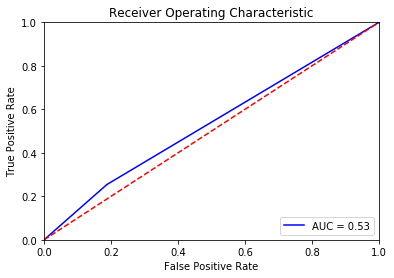

In [13]:
clf = featureExtraction(X)

In [14]:
X = dropUnImportantFeatures(X, clf, 0.0002)
X.info()

Dropped column count:  2847
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Columns: 607 entries, disbursed_amount to SI_24487
dtypes: float64(15), int64(11), object(1), uint8(580)
memory usage: 177.0+ MB


In [15]:
train = X.drop('Current_pincode_ID', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=41)

Mean CV Training ROC AUC Score:  0.5307079199023677
ROC AUC Score:  0.5348552875105003


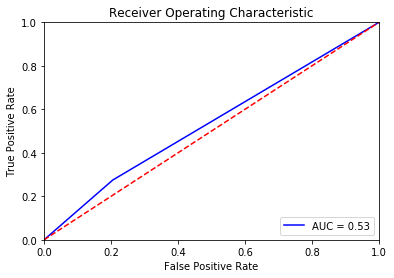

In [17]:
C50(X_train, X_test, y_train, y_test)

Mean CV Training ROC AUC Score:  0.5843773295003172
ROC AUC Score:  0.5926350902279325


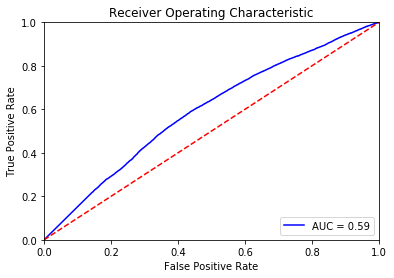

In [18]:
NB(X_train, X_test, y_train, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:122: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:122: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


Running the model for k =  83
ROC AUC Score:  0.6124302075156882


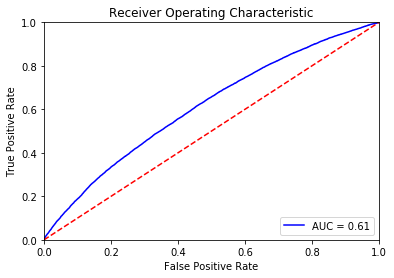

In [19]:
KNN(X_train, X_test, y_train, y_test)

Mean CV Training ROC AUC Score:  0.6562638746232273
ROC AUC Score:  0.6592703408324421


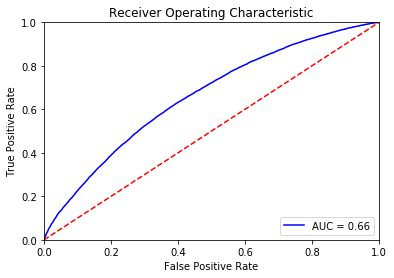

In [20]:
RF(X_train, X_test, y_train, y_test)